![title](../../images/header.png)

CEO data quality assessment
-------
This notebook assessing differences in CEO validation and review

###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Set the display option to a large value to prevent text wrapping
pd.set_option('display.max_colwidth', None)

In [2]:
# read cleaned merged data to evaluate
ceo = pd.read_csv('/home/sepal-user/module_results/esbae/COG/COG_all_ceo_2023_clean.csv')

In [3]:
# read CEO output from QC project
ceo_qc = pd.read_csv('/home/sepal-user/module_results/esbae/COG/ceo-CQ_SUIVI_MNV_2022_2023_CONGO-sample-data.csv')

In [4]:
# output file CEO validated data with QC
ceo_qc_data_out =  '/home/sepal-user/module_results/esbae/COG/COG_all_ceo_2023_clean_qc.csv'

In [5]:
len(ceo)

3227

In [6]:
print(ceo.dtypes)

ID                          int64
plotid                      int64
sampleid                    int64
sample_internal_id          int64
lon                       float64
lat                       float64
collection_time            object
sample_geom                object
Ref_FNF_2022                int64
Ref_NFtype_2022           float64
Ref_Ftype_2022            float64
Ref_FNF_2023                int64
Ref_NFtype_2023           float64
Ref_Ftype_2023            float64
Ref_Change_2023             int64
Ref_Change_Year             int64
Ref_Change_Type_2023       object
Ref_Driver1_2023           object
Ref_Fire_2023             float64
Ref_Change2_2023            int64
Ref_Change2_Type_2023      object
Ref_Driver2_2023           object
Ref_Fire2_2023             object
Commentaires               object
collection                 object
interpreted                 int64
Ref_Change_Bin              int64
Ref_LCover_2022             int64
Ref_Change_Year_2023       object
Ref_Change_LCo

In [7]:
print(ceo_qc.dtypes)

plotid                                                       int64
sampleid                                                     int64
sample_internal_id                                           int64
lon                                                        float64
lat                                                        float64
email                                                       object
flagged                                                       bool
collection_time                                             object
analysis_duration                                           object
imagery_title                                               object
imagery_attributions                                       float64
sample_geom                                                 object
forêt ou non-forêt en 2022?                                 object
Type de non-forêt en 2022                                   object
Type de forêt en 2022                                       ob

In [8]:
ceo_qc['collection'] = 'QC_2023'

In [9]:
print(ceo_qc.columns.values)

['plotid' 'sampleid' 'sample_internal_id' 'lon' 'lat' 'email' 'flagged'
 'collection_time' 'analysis_duration' 'imagery_title'
 'imagery_attributions' 'sample_geom' 'forêt ou non-forêt en 2022?'
 'Type de non-forêt en 2022' 'Type de forêt en 2022'
 'Définir la strate en 2023 ' 'Type de non-forêt en 2023'
 'Type de forêt en 2023'
 'Y-a t-il un changement négatif sur la période 2022-2023'
 'Quel type de changement ? ' "Indiquez l'année du changement "
 'Type de moteur pour changement 1' 'Le feu a t-il causé le changement ?'
 'Décrivez autres' 'y-a t-il un second changement ?'
 'Type du changement 2 (1)' 'Type de moteur pour changement 2 (1)'
 'Le feu a t-il causé le changement ?.1' 'Décrivez autres (1) (0)'
 'Commentaires' 'collection']


In [10]:
ceo['Ref_Change_Type_2023'].value_counts()

Ref_Change_Type_2023
Stable    2081
NF        1108
Deg         20
Def         18
Name: count, dtype: int64

In [11]:
# Step 1: Sort the DataFrame by 'collection_time' in ascending order
ceo_qc.sort_values(by='collection_time', ascending=True, inplace=True)

# Step 2: Remove duplicates keeping the first occurrence (most recent 'plotid')
ceo_qc.drop_duplicates(subset='sample_geom', keep='first', inplace=True)

# Step 3: Reset the index
ceo_qc.reset_index(drop=True, inplace=True)

# Step 4: Add 'collection' column with the collection counter
#ceo_qc['collection'] = "QC 2023"

# Step 5: Add 'interpreted' column: 1 if 'email' is not null, otherwise 0
ceo_qc['interpreted_qc'] = np.where(ceo_qc['email'].notna(), '1', '0')

# Specify the columns you want to keep in the merged DataFrame
columns_to_keep = ['plotid', 'sampleid', 'sample_internal_id', 'lon', 'lat', 'collection_time','email',
                   'sample_geom', 'forêt ou non-forêt en 2022?', 'Type de non-forêt en 2022', 'Type de forêt en 2022', 
                   'Définir la strate en 2023 ', 'Type de non-forêt en 2023', 'Type de forêt en 2023', 
                   'Y-a t-il un changement négatif sur la période 2022-2023', 'Quel type de changement ? ',
                   'Type de moteur pour changement 1', 'Le feu a t-il causé le changement ?','Décrivez autres',
                   'y-a t-il un second changement ?', 'Type du changement 2 (1)', 
                   'Type de moteur pour changement 2 (1)', 'Le feu a t-il causé le changement ?.1',
                   'Commentaires', 'collection','interpreted_qc']

# Select only the specified columns
ceo_qc = ceo_qc[columns_to_keep]

# Create a dictionary to map old column names to new column names
column_mapping = {
    'forêt ou non-forêt en 2022?': 'QC_FNF_2022', 
    'Type de non-forêt en 2022':'QC_NFtype_2022',
    'Type de forêt en 2022' :'QC_Ftype_2022',
    'Définir la strate en 2023 ':'QC_FNF_2023',
    'Type de non-forêt en 2023':'QC_NFtype_2023',
    'Type de forêt en 2023':'QC_Ftype_2023',
    'Décrivez autres':'Other_Desc',
    'Y-a t-il un changement négatif sur la période 2022-2023':'QC_Change_2023',
    'Quel type de changement ? ':'QC_Change_Type_2023',
    'Type de moteur pour changement 1':'QC_Driver1_2023',
    'Le feu a t-il causé le changement ?':'QC_Fire_2023',
     'y-a t-il un second changement ?':'QC_Change2_2023',
    'Type du changement 2 (1)':'QC_Change2_Type_2023',
    'Type de moteur pour changement 2 (1)':'QC_Driver2_2023',
    'Le feu a t-il causé le changement ?.1':'QC_Fire2_2023',
}

# Use the rename() method to rename the columns
ceo_qc_clean = ceo_qc.rename(columns=column_mapping)

# Define the replacements as a dictionary
replace_dict = {  
    'QC_FNF_2022': {'non-forêt': '0', 'forêt': '1'},
    'QC_Ftype_2022': {'1 - forêt dense': '1', '2 - forêt dense sèche': '2', '3 - forêt secondaire': '3','4- forêt claire': '4','7 - forêt mangrove': '7',
                 '8 - forêt marécageuse': '8', '9 - forêt galérie': '9','10 - plantation forestière': '10', '11- savane arborée': '11'},
    'QC_NFtype_2022': {'savane arborée/arbustive': '12', 'savane herbacée': '13','prairie aquatique': '14', 'sol nu végétation éparse': '15',
                  'terres cultivées annuelles': '16', ' zone baties': '17', 'eau ': '18', 'terres cultivées permanentes':'16'},
    'QC_FNF_2023': {'non-forêt': '0', 'forêt': '1'},
    'QC_Ftype_2023': {'1 - forêt dense': '1', '2 - forêt dense sèche': '2', '3 - forêt secondaire': '3','4- forêt claire': '4','7 - forêt mangrove': '7',
                 '8 - forêt marécageuse': '8', '9 - forêt galérie': '9','10 - plantation forestière': '10', '11- savane arborée': '11'},
    'QC_NFtype_2023': {'savane arbustive/arborée': '12', 'savane herbacée': '13','prairie aquatique': '14', 'sol nu végétation éparse': '15',
                  'terres cultivées annuelles': '16', 'zone baties': '17', 'eau': '18', 'terres cultivées permanentes':'16'},
    'QC_Change_2023': {'Oui':'1','Non':'0','':'0'},
    'QC_Change_2023': {'Oui':'1','Non':'0','':'0'},
    'QC_Change2_2023': {'Oui':'1','Non':'0','':'0'},
    'QC_Fire_2023': {'oui':'1','non':'0','':'0'},
    'QC_Fire2_2023': {'Oui':'1','Non':'0','':'0'},
    'QC_Regeneration': {'Oui':'1','Non':'0','':'0'},
    'QC_Change_Type_2023': {'Dégradation':'Deg','Déforestation ':'Def','':'0'},
    'QC_Change2_Type_2023': {'Dégradation':'Deg','Déforestation ':'Def','':'0'},
}

# Use the replace() method to replace strings in specified columns
ceo_qc_clean.replace(replace_dict, inplace=True)

ceo_qc_clean = ceo_qc_clean.copy()
columns_to_fill = ['QC_Change_2023','QC_Change2_2023']
# Set NaN values in the selected columns to 0
ceo_qc_clean[columns_to_fill] = ceo_qc_clean[columns_to_fill].fillna('0')
ceo_qc_clean['collection'].value_counts(dropna=False)

collection
QC_2023    969
Name: count, dtype: int64

In [12]:
ceo_qc_clean.drop(ceo_qc_clean[ceo_qc_clean['interpreted_qc'] == '0'].index, inplace=True)
len(ceo_qc_clean)

969

In [13]:
print(ceo_qc_clean.dtypes)

plotid                    int64
sampleid                  int64
sample_internal_id        int64
lon                     float64
lat                     float64
collection_time          object
email                    object
sample_geom              object
QC_FNF_2022              object
QC_NFtype_2022           object
QC_Ftype_2022            object
QC_FNF_2023              object
QC_NFtype_2023           object
QC_Ftype_2023            object
QC_Change_2023           object
QC_Change_Type_2023      object
QC_Driver1_2023          object
QC_Fire_2023             object
Other_Desc              float64
QC_Change2_2023          object
QC_Change2_Type_2023     object
QC_Driver2_2023          object
QC_Fire2_2023            object
Commentaires             object
collection               object
interpreted_qc           object
dtype: object


In [14]:
ceo_qc_clean.head()

,plotid,sampleid,sample_internal_id,lon,lat,collection_time,email,sample_geom,QC_FNF_2022,QC_NFtype_2022,QC_Ftype_2022,QC_FNF_2023,QC_NFtype_2023,QC_Ftype_2023,QC_Change_2023,QC_Change_Type_2023,QC_Driver1_2023,QC_Fire_2023,Other_Desc,QC_Change2_2023,QC_Change2_Type_2023,QC_Driver2_2023,QC_Fire2_2023,Commentaires,collection,interpreted_qc
0,2,2,764700553,17.682124,0.133894,2024-10-15 11:09,ndandoularissa7@gmail.com,POINT(17.68212364225922 0.133893893098016),1,NaN,1,1,NaN,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,QC_2023,1
1,4,4,764700601,16.598037,0.077929,2024-10-15 11:15,ndandoularissa7@gmail.com,POINT(16.59803675738378 0.077928850897369),1,NaN,1,1,NaN,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,QC_2023,1
2,5,5,764700608,14.588955,0.887850,2024-10-15 11:21,ndandoularissa7@gmail.com,POINT(14.588954624450473 0.88784991105953),1,NaN,1,1,NaN,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,QC_2023,1
3,16,16,764700464,17.480272,2.813928,2024-10-15 11:24,ndandoularissa7@gmail.com,POINT(17.480272197917564 2.813927711740196),1,NaN,1,1,NaN,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,QC_2023,1
4,20,20,764700482,16.936342,1.005439,2024-10-15 11:25,ndandoularissa7@gmail.com,POINT(16.93634229338319 1.005439381750775),1,NaN,1,1,NaN,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,QC_2023,1


##### clean up QC data

In [15]:
ceo_qc_clean.loc[ceo_qc_clean['QC_NFtype_2022'].notna(), 'QC_Change_Type_2023'] = 'NF'
ceo_qc_clean.loc[ceo_qc_clean['QC_NFtype_2022'].notna(), 'QC_Change_2023'] = '0'
ceo_qc_clean.loc[ceo_qc_clean['QC_NFtype_2022'].notna(), 'QC_Change_Year'] = np.nan
ceo_qc_clean.loc[ceo_qc_clean['QC_NFtype_2022'].notna(), 'QC_Driver1_2023'] = np.nan

In [16]:
ceo_qc_clean['QC_Change_Bin'] = ceo_qc_clean['QC_Change_2023']
ceo_qc_clean['QC_Change_Bin'].value_counts(dropna=False)

QC_Change_Bin
0    967
1      2
Name: count, dtype: int64

In [17]:
ceo_qc_clean['QC_NFtype_2022'].value_counts(dropna=False)

QC_NFtype_2022
NaN    659
12     196
13      73
16      25
14       7
17       5
18       3
15       1
Name: count, dtype: int64

In [18]:
ceo_qc_clean['QC_FNF_2022'].value_counts(dropna=False)

QC_FNF_2022
1    659
0    310
Name: count, dtype: int64

In [19]:
ceo_qc_clean['QC_Change_Year'].value_counts(dropna=False)

QC_Change_Year
NaN    969
Name: count, dtype: int64

In [20]:
#ceo_qc_clean.drop(ceo_qc_clean[ceo_qc_clean['QC_NFtype_2022'] == 'je ne sais pas'].index, inplace=True)

In [21]:
ceo_qc_clean['QC_Ftype_2022'].value_counts(dropna=False)

QC_Ftype_2022
1      334
NaN    310
3      190
9       72
8       48
4       10
10       4
7        1
Name: count, dtype: int64

In [22]:
ceo_qc_clean['QC_Change_Type_2023'].value_counts(dropna=False)

QC_Change_Type_2023
NaN    657
NF     310
Def      1
Deg      1
Name: count, dtype: int64

In [23]:
ceo_qc_clean = ceo_qc_clean.copy()
ceo_qc_clean.loc[:, 'QC_LCover_2022'] = ceo_qc_clean['QC_Ftype_2022'].fillna(ceo_qc_clean['QC_NFtype_2022'])
ceo_qc_clean['QC_LCover_2022'] = ceo_qc_clean['QC_LCover_2022']
ceo_qc_clean['QC_LCover_2022'].value_counts(dropna=False)

QC_LCover_2022
1     334
12    196
3     190
13     73
9      72
8      48
16     25
4      10
14      7
17      5
10      4
18      3
15      1
7       1
Name: count, dtype: int64

In [24]:
# Confirm the column is now of integet type
print(ceo_qc_clean['QC_LCover_2022'].dtype)

object


In [25]:
def f(x):
  if x['QC_FNF_2022'] == '0' : return 'NF'
  elif x['QC_Change_Type_2023'] == 'Def': return 'Def'
  elif x['QC_Change_Type_2023'] == 'Deg' : return 'Deg'
  else: return 'Stable'

ceo_qc_clean.loc[:, 'QC_Change_Type_2023'] = ceo_qc_clean.apply(f, axis=1)
ceo_qc_clean['QC_Change_Type_2023'].value_counts()

QC_Change_Type_2023
Stable    657
NF        310
Def         1
Deg         1
Name: count, dtype: int64

In [26]:
def y(x):
  if x['QC_Change_Type_2023'] == 'Def': return 'Def2023'
  elif x['QC_Change_Type_2023'] == 'Deg' : return 'Deg2023'
  elif x['QC_Change_Type_2023'] == 'NF' : return 'NF'
  elif x['QC_Change_Type_2023'] == 'Stable' : return 'Stable'
  else: return ''

ceo_qc_clean.loc[:,'QC_Change_Year_2023'] = ceo_qc_clean.apply(y, axis=1)

change_counts = ceo_qc_clean['QC_Change_Year_2023'].value_counts()
change_counts = change_counts.sort_index()
print(change_counts)

QC_Change_Year_2023
Def2023      1
Deg2023      1
NF         310
Stable     657
Name: count, dtype: int64


In [27]:
# Define the new column based on conditions
ceo_qc_clean.loc[:,'QC_Change_LCover_2023'] = ceo_qc_clean.apply(lambda row: f"{row['QC_Change_Type_2023']}_{row['QC_LCover_2022']}", axis=1)
ceo_qc_clean['QC_Change_LCover_2023'].value_counts()

QC_Change_LCover_2023
Stable_1     334
NF_12        196
Stable_3     188
NF_13         73
Stable_9      72
Stable_8      48
NF_16         25
Stable_4      10
NF_14          7
NF_17          5
Stable_10      4
NF_18          3
NF_15          1
Def_3          1
Stable_7       1
Deg_3          1
Name: count, dtype: int64

##### merge CEO and QC data

In [28]:
# Merge ceo_qc_clean and ceo on 'lon' and 'lat' columns
merged_ceo_qc = pd.merge(ceo_qc_clean, ceo, how='inner', on=['sample_geom'], suffixes=('_qc_clean', '_ceo'))

# Display the merged dataframe
merged_ceo_qc.head()

,plotid_qc_clean,sampleid_qc_clean,sample_internal_id_qc_clean,lon_qc_clean,lat_qc_clean,collection_time_qc_clean,email,sample_geom,QC_FNF_2022,QC_NFtype_2022,QC_Ftype_2022,QC_FNF_2023,QC_NFtype_2023,QC_Ftype_2023,QC_Change_2023,QC_Change_Type_2023,QC_Driver1_2023,QC_Fire_2023,Other_Desc,QC_Change2_2023,QC_Change2_Type_2023,QC_Driver2_2023,QC_Fire2_2023,Commentaires_qc_clean,collection_qc_clean,interpreted_qc,QC_Change_Year,QC_Change_Bin,QC_LCover_2022,QC_Change_Year_2023,QC_Change_LCover_2023,ID,plotid_ceo,sampleid_ceo,sample_internal_id_ceo,lon_ceo,lat_ceo,collection_time_ceo,Ref_FNF_2022,Ref_NFtype_2022,Ref_Ftype_2022,Ref_FNF_2023,Ref_NFtype_2023,Ref_Ftype_2023,Ref_Change_2023,Ref_Change_Year,Ref_Change_Type_2023,Ref_Driver1_2023,Ref_Fire_2023,Ref_Change2_2023,Ref_Change2_Type_2023,Ref_Driver2_2023,Ref_Fire2_2023,Commentaires_ceo,collection_ceo,interpreted,Ref_Change_Bin,Ref_LCover_2022,Ref_Change_Year_2023,Ref_Change_LCover_2023,Def2023,Deg2023,Defall,Degall,Stable,NF,DensFor,DensDryFor,SecFor,DryOpenFor,Mangrove,Swamp,Gallery,Plantation,Woodland,Shrubland,Grassland,Aquatic,Bare,Cultivated,Builtup,Water,DensFor_Def,DensDryFor_Def,SecFor_Def,DryOpenFor_Def,Mangrove_Def,Swamp_Def,Gallery_Def,Plantation_Def,Woodland_Def,DensFor_Deg,DensDryFor_Deg,SecFor_Deg,DryOpenFor_Deg,Mangrove_Deg,Swamp_Deg,Gallery_Deg,Plantation_Deg,Woodland_Deg,DensFor_Stable,DensDryFor_Stable,SecFor_Stable,DryOpenFor_Stable,Mangrove_Stable,Swamp_Stable,Gallery_Stable,Plantation_Stable,Woodland_Stable,ArtAg,ArtFor,IndFor,InfraR,Urb,IndAg,ArtMine,IndMine,Other,ISO
0,2,2,764700553,17.682124,0.133894,2024-10-15 11:09,ndandoularissa7@gmail.com,POINT(17.68212364225922 0.133893893098016),1,NaN,1,1,NaN,1,0,Stable,NaN,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,QC_2023,1,NaN,0,1,Stable,Stable_1,1,2,2,754911310,17.682124,0.133894,2024-06-17 12:33,1,NaN,8.0,1,NaN,8.0,0,0,Stable,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,coll_2023_1,1,0,8,Stable,Stable_8,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG
1,4,4,764700601,16.598037,0.077929,2024-10-15 11:15,ndandoularissa7@gmail.com,POINT(16.59803675738378 0.077928850897369),1,NaN,1,1,NaN,1,0,Stable,NaN,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,QC_2023,1,NaN,0,1,Stable,Stable_1,3,4,4,754911312,16.598037,0.077929,2024-06-17 12:46,1,NaN,8.0,1,NaN,8.0,0,0,Stable,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,coll_2023_1,1,0,8,Stable,Stable_8,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG
2,5,5,764700608,14.588955,0.887850,2024-10-15 11:21,ndandoularissa7@gmail.com,POINT(14.588954624450473 0.88784991105953),1,NaN,1,1,NaN,1,0,Stable,NaN,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,QC_2023,1,NaN,0,1,Stable,Stable_1,4,5,5,754911313,14.588955,0.887850,2024-06-17 13:06,1,NaN,1.0,1,NaN,1.0,0,0,Stable,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,coll_2023_1,1,0,1,Stable,Stable_1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG
3,16,16,764700464,17.480272,2.813928,2024-10-15 11:24,ndandoularissa7@gmail.com,POINT(17.480272197917564 2.813927711740196),1,NaN,1,1,NaN,1,0,Stable,NaN,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,QC_2023,1,NaN,0,1,Stable,Stable_1,13,16,16,754911324,17.480272,2.813928,2024-06-17 14:00,1,NaN,1.0,1,NaN,1.0,0,0,Stable,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,coll_2023_1,1,0,1,Stable,Stable_1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG
4,20,20,764700482,16.936342,1.005439,2024-10-15 11:25,ndandoularissa7@gmail.com,POINT(16.93634229338319 1.005439381750775),1,NaN,1,1,NaN,1,0,Stable,NaN,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,QC_2023,1,NaN,0,1,Stable,Stable_1,17,20,20,754911328,16.936342,1.005439,2024-06-17 14:06,1,NaN,7.0,1

In [29]:
len(merged_ceo_qc)

969

In [30]:
# this might take some time
unique_check = merged_ceo_qc['sample_geom'].nunique() == len(merged_ceo_qc['sample_geom'])

# Print the result
if unique_check:
    print("All values are unique!")
else:
    print("F$%§!")

All values are unique!


In [31]:
#merged_ceo_qc = merged_ceo_qc.drop_duplicates(subset='sample_geom', keep='first', inplace=True)

In [32]:
print(merged_ceo_qc.dtypes)

plotid_qc_clean                  int64
sampleid_qc_clean                int64
sample_internal_id_qc_clean      int64
lon_qc_clean                   float64
lat_qc_clean                   float64
collection_time_qc_clean        object
email                           object
sample_geom                     object
QC_FNF_2022                     object
QC_NFtype_2022                  object
QC_Ftype_2022                   object
QC_FNF_2023                     object
QC_NFtype_2023                  object
QC_Ftype_2023                   object
QC_Change_2023                  object
QC_Change_Type_2023             object
QC_Driver1_2023                 object
QC_Fire_2023                    object
Other_Desc                     float64
QC_Change2_2023                 object
QC_Change2_Type_2023            object
QC_Driver2_2023                 object
QC_Fire2_2023                   object
Commentaires_qc_clean           object
collection_qc_clean             object
interpreted_qc           

In [33]:
merged_ceo_qc['Ref_FNF_2022'] = merged_ceo_qc['QC_FNF_2022'].astype(int)
merged_ceo_qc['QC_FNF_2022'] = merged_ceo_qc['QC_FNF_2022'].astype(int)

In [34]:
merged_ceo_qc['QC_LCover_2022'].value_counts(dropna=False)

QC_LCover_2022
1     334
12    196
3     190
13     73
9      72
8      48
16     25
4      10
14      7
17      5
10      4
18      3
15      1
7       1
Name: count, dtype: int64

In [35]:
merged_ceo_qc['QC_Change_Type_2023'].value_counts(dropna=False)

QC_Change_Type_2023
Stable    657
NF        310
Def         1
Deg         1
Name: count, dtype: int64

In [36]:
merged_ceo_qc['Ref_LCover_2022'].value_counts(dropna=False)

Ref_LCover_2022
1     341
12    175
3     150
13    100
9      63
8      52
16     35
14     16
15     14
4       7
17      5
7       4
10      4
18      3
Name: count, dtype: int64

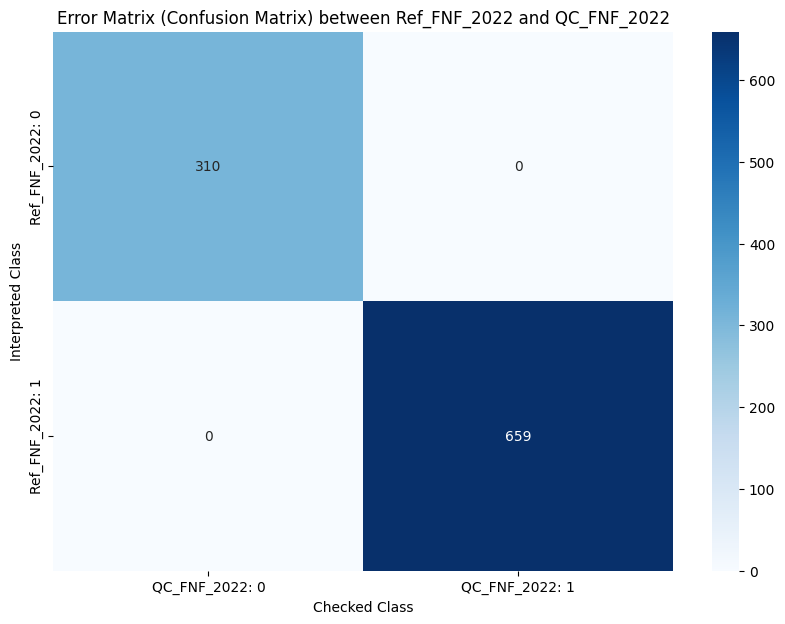

In [37]:
# Step 1: Create the confusion matrix (error matrix)
error_matrix_FNF = confusion_matrix(merged_ceo_qc['Ref_FNF_2022'], merged_ceo_qc['QC_FNF_2022'])
# Step 2: Convert confusion matrix to a DataFrame for better readability
error_matrix_FNF_df = pd.DataFrame(
    error_matrix_FNF, 
    index=['Ref_FNF_2022: ' + str(i) for i in sorted(merged_ceo_qc['Ref_FNF_2022'].unique())], 
    columns=['QC_FNF_2022: ' + str(i) for i in sorted(merged_ceo_qc['QC_FNF_2022'].unique())]
)

# Step 3: Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(error_matrix_FNF_df, annot=True, cmap='Blues', fmt='g', cbar=True)

# Add titles and labels
plt.title('Error Matrix (Confusion Matrix) between Ref_FNF_2022 and QC_FNF_2022')
plt.ylabel('Interpreted Class')
plt.xlabel('Checked Class')

# Show the plot
plt.show()

In [38]:
# Calculate the sum of diagonal elements (correctly classified observations)
correctly_classified_FNF = np.trace(error_matrix_FNF_df)

# Calculate the total number of observations
total_observations_FNF = error_matrix_FNF_df.to_numpy().sum()

# Calculate the percentage agreement
percentage_agreement_FNF = (correctly_classified_FNF / total_observations_FNF) * 100

print(f"General Percentage Agreement: {percentage_agreement_FNF:.2f}%")

General Percentage Agreement: 100.00%


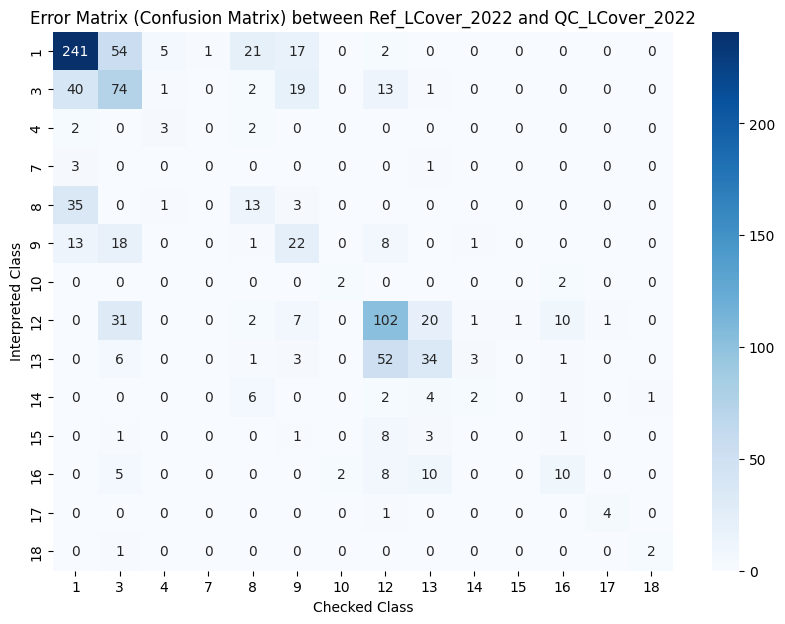

In [39]:
# reference and predicted classes
ref_column = 'Ref_LCover_2022'  # Reference class column
qc_column = 'QC_LCover_2022'    # QC class column

# Ensure both columns are of integer type
merged_ceo_qc[ref_column] = pd.to_numeric(merged_ceo_qc[ref_column], errors='coerce')
merged_ceo_qc[qc_column] = pd.to_numeric(merged_ceo_qc[qc_column], errors='coerce')

# Drop any NaN values that might have resulted from coercion
merged_ceo_qc = merged_ceo_qc.dropna(subset=[ref_column, qc_column])

# Convert to integer after handling NaNs
merged_ceo_qc[ref_column] = merged_ceo_qc[ref_column].astype(int)
merged_ceo_qc[qc_column] = merged_ceo_qc[qc_column].astype(int)

# Now safely get unique expected classes
expected_classes = sorted(set(merged_ceo_qc[ref_column].unique()).union(set(merged_ceo_qc[qc_column].unique())))

# Step 2: Create the confusion matrix
error_matrix_LCover = confusion_matrix(
    merged_ceo_qc[ref_column],
    merged_ceo_qc[qc_column],
    labels=expected_classes  # Ensure all expected classes are included
)

# Step 3: Create a DataFrame from the confusion matrix with all expected classes as index and columns
error_matrix_LCover_df = pd.DataFrame(
    error_matrix_LCover, 
    index=expected_classes, 
    columns=expected_classes
)

# Step 4: Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(error_matrix_LCover_df, annot=True, cmap='Blues', fmt='g', cbar=True)

# Add titles and labels
plt.title('Error Matrix (Confusion Matrix) between Ref_LCover_2022 and QC_LCover_2022')
plt.ylabel('Interpreted Class')
plt.xlabel('Checked Class')

# Show the plot
plt.show()

In [40]:
# Calculate the sum of diagonal elements (correctly classified observations)
correctly_classified_LC = np.trace(error_matrix_LCover_df)

# Calculate the total number of observations
total_observations_LC = error_matrix_LCover_df.to_numpy().sum()

# Calculate the percentage agreement
percentage_agreement_LC = (correctly_classified_LC / total_observations_LC) * 100

print(f"General Percentage Agreement: {percentage_agreement_LC:.2f}%")

General Percentage Agreement: 52.53%


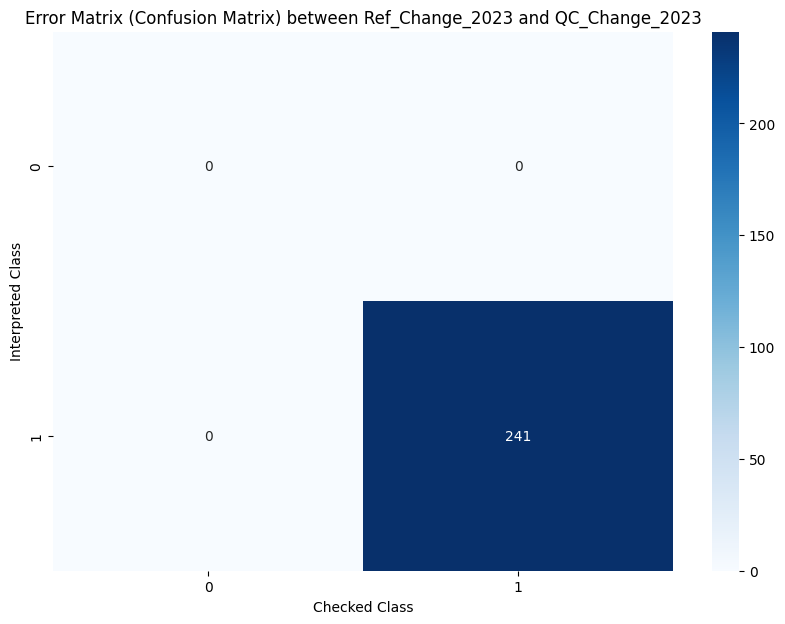

In [41]:
# Step 1: Create the confusion matrix (error matrix)
# Step 2: Convert confusion matrix to a DataFrame for better readability
error_matrix_FNF_df = pd.DataFrame(
    error_matrix_FNF, 
    index=['Ref_Change_2023: ' + str(i) for i in sorted(merged_ceo_qc['Ref_Change_2023'].unique())], 
    columns=['QC_Change_2022: ' + str(i) for i in sorted(merged_ceo_qc['QC_Change_2023'].unique())]
)

# Define all possible classes (adjust based on known possible classes)
all_possible_classes = sorted(set(range(0, 2)))  # Adjust the range as needed for known classes

# Step 2: Create the confusion matrix using all possible classes as labels
error_matrix_Change = confusion_matrix(
    merged_ceo_qc[ref_column],
    merged_ceo_qc[qc_column],
    labels=all_possible_classes  # Include all possible classes as labels
)

# Step 3: Create a DataFrame from the confusion matrix with all possible classes as index and columns
error_matrix_Change_df = pd.DataFrame(
    error_matrix_Change, 
    index=all_possible_classes, 
    columns=all_possible_classes
)

# Step 4: Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(error_matrix_Change_df, annot=True, cmap='Blues', fmt='g', cbar=True)

# Add titles and labels
plt.title('Error Matrix (Confusion Matrix) between Ref_Change_2023 and QC_Change_2023')
plt.ylabel('Interpreted Class')
plt.xlabel('Checked Class')

# Show the plot
plt.show()

In [42]:
# Calculate the sum of diagonal elements (correctly classified observations)
correctly_classified_Change = np.trace(error_matrix_Change_df)

# Calculate the total number of observations
total_observations_Change = error_matrix_Change_df.to_numpy().sum()

# Calculate the percentage agreement
percentage_agreement_Change = (correctly_classified_Change / total_observations_Change) * 100

print(f"General Percentage Agreement: {percentage_agreement_Change:.2f}%")

General Percentage Agreement: 100.00%


In [43]:
print(merged_ceo_qc.columns.tolist())

['plotid_qc_clean', 'sampleid_qc_clean', 'sample_internal_id_qc_clean', 'lon_qc_clean', 'lat_qc_clean', 'collection_time_qc_clean', 'email', 'sample_geom', 'QC_FNF_2022', 'QC_NFtype_2022', 'QC_Ftype_2022', 'QC_FNF_2023', 'QC_NFtype_2023', 'QC_Ftype_2023', 'QC_Change_2023', 'QC_Change_Type_2023', 'QC_Driver1_2023', 'QC_Fire_2023', 'Other_Desc', 'QC_Change2_2023', 'QC_Change2_Type_2023', 'QC_Driver2_2023', 'QC_Fire2_2023', 'Commentaires_qc_clean', 'collection_qc_clean', 'interpreted_qc', 'QC_Change_Year', 'QC_Change_Bin', 'QC_LCover_2022', 'QC_Change_Year_2023', 'QC_Change_LCover_2023', 'ID', 'plotid_ceo', 'sampleid_ceo', 'sample_internal_id_ceo', 'lon_ceo', 'lat_ceo', 'collection_time_ceo', 'Ref_FNF_2022', 'Ref_NFtype_2022', 'Ref_Ftype_2022', 'Ref_FNF_2023', 'Ref_NFtype_2023', 'Ref_Ftype_2023', 'Ref_Change_2023', 'Ref_Change_Year', 'Ref_Change_Type_2023', 'Ref_Driver1_2023', 'Ref_Fire_2023', 'Ref_Change2_2023', 'Ref_Change2_Type_2023', 'Ref_Driver2_2023', 'Ref_Fire2_2023', 'Commentaires

In [44]:
merged_ceo_qc = merged_ceo_qc.rename(columns={'lon_qc_clean': 'lon'})
merged_ceo_qc = merged_ceo_qc.rename(columns={'lat_qc_clean': 'lat'})

In [45]:
#want_columns = ['plotid_qc_clean', 'sampleid_qc_clean', 'sample_internal_id_qc_clean', 'lon', 'lat', 'sample_geom', 'pl_sampleid', 
#                'pl_plotid_old', 'pl_id', 'QC_FNF_2022', 'QC_Regeneration', 'QC_Change_2023', 'QC_Change_Type_2023', 'QC_ArtFor', 'QC_ArtMine', 
#                'QC_InfraR', 'QC_Urb', 'QC_IndFor', 'QC_Other', 'QC_Other_Desc', 'QC_IndMine', 'QC_IndAg', 'QC_ArtAg', 'QC_NFtype_2022', 'QC_Ftype_2022', 
#                'pl_collection', 'interpreted_qc', 'QC_LCover_2022', 'QC_Change_Year_2023', 'QC_Change_LCover_2023', 'ID', 'plotid_ceo', 'sampleid_ceo', 
#                'lon_ceo', 'lat_ceo', 'Ref_FNF_2022', 'Ref_Regeneration', 'Ref_Change_2023', 'Ref_Change_Type_2023', 'ArtFor', 'ArtMine', 'InfraR', 
#                'Urb', 'IndFor', 'Other', 'Other_Desc', 'IndMine', 'IndAg', 'ArtAg', 'Ref_NFtype_2022', 'Ref_Ftype_2022', 'collection', 'interpreted', 
#                'Ref_LCover_2022', 'Ref_Change_Year_2023', 'Ref_Change_LCover_2023']

In [46]:
#merged_ceo_qc_select = merged_ceo_qc[want_columns]

##### replace QC data into ceo 

In [47]:
# Step 1: Remove rows with empty 'sample_geom' in ceo_qc
ceo_qc_filtered = ceo_qc_clean[ceo_qc_clean['sample_geom'].notna()]
len(ceo_qc_filtered)

969

In [48]:
# Step 1: Merge the DataFrames on 'sample_geom'
merged_df = ceo.merge(ceo_qc_filtered,
                       on='sample_geom', 
                       how='left', 
                       suffixes=('', '_qc'))

In [49]:
print(merged_df.dtypes)

ID                          int64
plotid                      int64
sampleid                    int64
sample_internal_id          int64
lon                       float64
lat                       float64
collection_time            object
sample_geom                object
Ref_FNF_2022                int64
Ref_NFtype_2022           float64
Ref_Ftype_2022            float64
Ref_FNF_2023                int64
Ref_NFtype_2023           float64
Ref_Ftype_2023            float64
Ref_Change_2023             int64
Ref_Change_Year             int64
Ref_Change_Type_2023       object
Ref_Driver1_2023           object
Ref_Fire_2023             float64
Ref_Change2_2023            int64
Ref_Change2_Type_2023      object
Ref_Driver2_2023           object
Ref_Fire2_2023             object
Commentaires               object
collection                 object
interpreted                 int64
Ref_Change_Bin              int64
Ref_LCover_2022             int64
Ref_Change_Year_2023       object
Ref_Change_LCo

In [50]:
merged_df = merged_df.drop(columns=['Commentaires_qc','collection_time_qc','lon_qc','lat_qc','plotid_qc',
                                    'sampleid_qc','sample_internal_id_qc'])

In [51]:
merged_df['collection'] = merged_df['collection_qc'].combine_first(merged_df['collection'])

In [52]:
merged_df['collection'].value_counts(dropna=False)

collection
coll_2023_2    1900
QC_2023         969
coll_2023_1     358
Name: count, dtype: int64

In [53]:
len(merged_df)

3227

In [54]:
merged_df['QC_Change_Type_2023'].value_counts(dropna=False)

QC_Change_Type_2023
NaN       2258
Stable     657
NF         310
Deg          1
Def          1
Name: count, dtype: int64

In [55]:
merged_df['Ref_Change_Type_2023'].value_counts(dropna=False)

Ref_Change_Type_2023
Stable    2081
NF        1108
Deg         20
Def         18
Name: count, dtype: int64

In [56]:
merged_df['QC_LCover_2022'].value_counts(dropna=False)

QC_LCover_2022
NaN    2258
1       334
12      196
3       190
13       73
9        72
8        48
16       25
4        10
14        7
17        5
10        4
18        3
15        1
7         1
Name: count, dtype: int64

In [57]:
print(merged_df.columns.tolist())

['ID', 'plotid', 'sampleid', 'sample_internal_id', 'lon', 'lat', 'collection_time', 'sample_geom', 'Ref_FNF_2022', 'Ref_NFtype_2022', 'Ref_Ftype_2022', 'Ref_FNF_2023', 'Ref_NFtype_2023', 'Ref_Ftype_2023', 'Ref_Change_2023', 'Ref_Change_Year', 'Ref_Change_Type_2023', 'Ref_Driver1_2023', 'Ref_Fire_2023', 'Ref_Change2_2023', 'Ref_Change2_Type_2023', 'Ref_Driver2_2023', 'Ref_Fire2_2023', 'Commentaires', 'collection', 'interpreted', 'Ref_Change_Bin', 'Ref_LCover_2022', 'Ref_Change_Year_2023', 'Ref_Change_LCover_2023', 'Def2023', 'Deg2023', 'Defall', 'Degall', 'Stable', 'NF', 'DensFor', 'DensDryFor', 'SecFor', 'DryOpenFor', 'Mangrove', 'Swamp', 'Gallery', 'Plantation', 'Woodland', 'Shrubland', 'Grassland', 'Aquatic', 'Bare', 'Cultivated', 'Builtup', 'Water', 'DensFor_Def', 'DensDryFor_Def', 'SecFor_Def', 'DryOpenFor_Def', 'Mangrove_Def', 'Swamp_Def', 'Gallery_Def', 'Plantation_Def', 'Woodland_Def', 'DensFor_Deg', 'DensDryFor_Deg', 'SecFor_Deg', 'DryOpenFor_Deg', 'Mangrove_Deg', 'Swamp_Deg', 

In [58]:
merged_df['interpreted_qc'] = merged_df['interpreted_qc'].astype(float).fillna(0).astype(int)
merged_df['interpreted_qc'].value_counts(dropna=False)

interpreted_qc
0    2258
1     969
Name: count, dtype: int64

In [59]:
merged_df['QC_LCover_2022'] = merged_df['QC_LCover_2022'].astype(float).fillna(0).astype(int)
merged_df['QC_LCover_2022'].value_counts(dropna=False)

QC_LCover_2022
0     2258
1      334
12     196
3      190
13      73
9       72
8       48
16      25
4       10
14       7
17       5
10       4
18       3
15       1
7        1
Name: count, dtype: int64

In [60]:
merged_df['Ref_LCover_2022'] = merged_df['Ref_LCover_2022'].astype(float).fillna(0).astype(int)
merged_df['Ref_LCover_2022'].value_counts(dropna=False)

Ref_LCover_2022
1     1162
12     553
3      525
13     314
8      201
9      190
16     104
14      57
15      48
4       29
17      18
18      14
10       8
7        4
Name: count, dtype: int64

In [61]:
# Check the current type of the column
print(merged_df['Ref_LCover_2022'].dtype)

int64


In [72]:
merged_df['Ref_LCover_2022'] = merged_df['Ref_LCover_2022'].astype('Int64')
merged_df['Ref_FNF_2022'] = merged_df['Ref_FNF_2022'].astype('Int64')
merged_df['Ref_Ftype_2022'] = merged_df['Ref_Ftype_2022'].astype(float).fillna(0).astype(int)
merged_df['Ref_NFtype_2022'] = merged_df['Ref_NFtype_2022'].astype(float).fillna(0).astype(int)
#merged_df['Ref_Change_Year_2023'] = merged_df['Ref_Change_Year_2023'].astype(float).fillna(0).astype(int)
#merged_df['interpreted_qc'] = merged_df['interpreted_qc'].astype(float).fillna(0).astype(int)

In [73]:
# Replace values in 'Ref' with 'QC' where 'interpreted_qc' is 1
# Ensure 'QC_Change_2023' is the same dtype as 'Ref_Change_2023'
merged_df['Ref_Change_2023'] = merged_df['Ref_Change_2023'].astype(merged_df['QC_Change_2023'].dtype)

merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_Ftype_2022'] = merged_df['QC_Ftype_2022'].fillna(0).astype(int)
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_NFtype_2022'] = merged_df['QC_NFtype_2022'].fillna(0).astype(int)
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_FNF_2022'] = merged_df['QC_FNF_2022'].fillna(0).astype(int)
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_Change_2023'] = merged_df['QC_Change_2023'].fillna(0).astype(int)
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_Change_Type_2023'] = merged_df['QC_Change_Type_2023']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_LCover_2022'] = merged_df['QC_LCover_2022'].fillna(0).astype(int)
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_Change_Year_2023'] = merged_df['QC_Change_Year_2023']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_Change_LCover_2023'] = merged_df['QC_Change_LCover_2023']

In [74]:
merged_df['QC_Change_Year_2023'].value_counts(dropna=False)

QC_Change_Year_2023
NaN        2258
Stable      657
NF          310
Deg2023       1
Def2023       1
Name: count, dtype: int64

In [75]:
merged_df['Ref_Change_Year_2023'].value_counts(dropna=False)

Ref_Change_Year_2023
Stable     2123
NF         1070
Deg2023      19
Def2023      15
Name: count, dtype: int64

In [76]:
merged_df['Ref_Change_Type_2023'].value_counts(dropna=False)

Ref_Change_Type_2023
Stable    2123
NF        1070
Deg         19
Def         15
Name: count, dtype: int64

In [77]:
merged_df['Ref_LCover_2022'].value_counts(dropna=False)

Ref_LCover_2022
1     1155
12     574
3      565
13     287
9      199
8      197
16      94
14      48
15      35
4       32
17      18
18      14
10       8
7        1
Name: count, dtype: Int64

In [78]:
merged_df.loc[:,'Def2023'] = np.where(merged_df['Ref_Change_Year_2023'] == 'Def2023', 1, 0)
merged_df.loc[:,'Deg2023'] = np.where(merged_df['Ref_Change_Year_2023'] == 'Deg2023', 1, 0)
merged_df['Deg2023'].value_counts(dropna=False)

Deg2023
0    3208
1      19
Name: count, dtype: int64

In [79]:
merged_df.loc[:,'Defall'] = np.where(merged_df['Ref_Change_Type_2023'] == 'Def', 1, 0)
merged_df.loc[:,'Degall'] = np.where(merged_df['Ref_Change_Type_2023'] == 'Deg', 1, 0)
merged_df['Defall'].value_counts(dropna=False)

Defall
0    3212
1      15
Name: count, dtype: int64

In [80]:
merged_df.loc[:,'Stable'] = np.where(merged_df['Ref_Change_Type_2023'] == 'Stable', 1, 0)
merged_df.loc[:,'NF'] = np.where(merged_df['Ref_Change_Type_2023'] == 'NF', 1, 0)
merged_df['Stable'].value_counts(dropna=False)

Stable
1    2123
0    1104
Name: count, dtype: int64

In [81]:
merged_df.loc[:,'DensFor'] = np.where(merged_df['Ref_LCover_2022'] == 1, 1, 0)
merged_df.loc[:,'DensDryFor'] = np.where(merged_df['Ref_LCover_2022'] == 2, 1, 0)
merged_df.loc[:,'SecFor'] = np.where(merged_df['Ref_LCover_2022'] == 3, 1, 0)
merged_df.loc[:,'DryOpenFor'] = np.where(merged_df['Ref_LCover_2022'] == 4, 1, 0)
merged_df.loc[:,'Mangrove'] = np.where(merged_df['Ref_LCover_2022'] == 7, 1, 0)
merged_df.loc[:,'Swamp'] = np.where(merged_df['Ref_LCover_2022'] == 8, 1, 0)
merged_df.loc[:,'Gallery'] = np.where(merged_df['Ref_LCover_2022'] == 9, 1, 0)
merged_df.loc[:,'Plantation'] = np.where(merged_df['Ref_LCover_2022'] == 10, 1, 0)
merged_df.loc[:,'Woodland'] = np.where(merged_df['Ref_LCover_2022'] == 11, 1, 0)
merged_df.loc[:,'Shrubland'] = np.where(merged_df['Ref_LCover_2022'] == 12, 1, 0)
merged_df.loc[:,'Grassland'] = np.where(merged_df['Ref_LCover_2022'] == 13, 1, 0)
merged_df.loc[:,'Aquatic'] = np.where(merged_df['Ref_LCover_2022'] == 14, 1, 0)
merged_df.loc[:,'Bare'] = np.where(merged_df['Ref_LCover_2022'] == 15, 1, 0)
merged_df.loc[:,'Cultivated'] = np.where(merged_df['Ref_LCover_2022'] == 16, 1, 0)
merged_df.loc[:,'Builtup'] = np.where(merged_df['Ref_LCover_2022'] == 17, 1, 0)
merged_df.loc[:,'Water'] = np.where(merged_df['Ref_LCover_2022'] == 18, 1, 0)
merged_df['Gallery'].value_counts(dropna=False)

Gallery
0    3028
1     199
Name: count, dtype: int64

In [82]:
merged_df.loc[:,'DensFor_Def'] = ((merged_df['DensFor'] == 1) & (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'DensDryFor_Def'] = ((merged_df['DensDryFor'] == 1) &  (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'SecFor_Def'] = ((merged_df['SecFor'] == 1) &  (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'DryOpenFor_Def'] = ((merged_df['DryOpenFor'] == 1) &  (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'Mangrove_Def'] = ((merged_df['Mangrove'] == 1) &  (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'Swamp_Def'] = ((merged_df['Swamp'] == 1) &  (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'Gallery_Def'] = ((merged_df['Gallery'] == 1) & (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'Plantation_Def'] = ((merged_df['Plantation'] == 1) &  (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'Woodland_Def'] = ((merged_df['Woodland'] == 1) & (merged_df['Defall'] == 1)).astype(int)
merged_df['SecFor_Def'].value_counts(dropna=False)

SecFor_Def
0    3214
1      13
Name: count, dtype: int64

In [83]:
merged_df.loc[:,'DensFor_Deg'] = ((merged_df['DensFor'] == 1) & (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'DensDryFor_Deg'] = ((merged_df['DensDryFor'] == 1) &  (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'SecFor_Deg'] = ((merged_df['SecFor'] == 1) & (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'DryOpenFor_Deg'] = ((merged_df['DryOpenFor'] == 1)& (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'Mangrove_Deg'] = ((merged_df['Mangrove'] == 1) & (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'Swamp_Deg'] = ((merged_df['Swamp'] == 1)& (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'Gallery_Deg'] = ((merged_df['Gallery'] == 1) & (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'Plantation_Deg'] = ((merged_df['Plantation'] == 1) & (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'Woodland_Deg'] = ((merged_df['Woodland'] == 1) & (merged_df['Degall'] == 1)).astype(int)
merged_df['DensFor_Deg'].value_counts(dropna=False)

DensFor_Deg
0    3224
1       3
Name: count, dtype: int64

In [84]:
merged_df.loc[:,'DensFor_Stable'] = ((merged_df['DensFor'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'DensDryFor_Stable'] = ((merged_df['DensDryFor'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'SecFor_Stable'] = ((merged_df['SecFor'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'DryOpenFor_Stable'] = ((merged_df['DryOpenFor'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'Mangrove_Stable'] = ((merged_df['Mangrove'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'Swamp_Stable'] = ((merged_df['Swamp'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'Gallery_Stable'] = ((merged_df['Gallery'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'Plantation_Stable'] = ((merged_df['Plantation'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'Woodland_Stable'] = ((merged_df['Woodland'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df['DensFor_Stable'].value_counts(dropna=False)

DensFor_Stable
0    2076
1    1151
Name: count, dtype: int64

In [85]:
merged_df.loc[merged_df['QC_Driver1_2023'] == 'agriculture paysanne', 'ArtAg'] = 1
merged_df.loc[merged_df['QC_Driver1_2023'] == 'foresterie artisanale <5ha', 'ArtFor'] = 1
merged_df.loc[merged_df['QC_Driver1_2023'] == 'foresterie industrielle >5ha', 'IndFor'] = 1
merged_df.loc[merged_df['QC_Driver1_2023'] == 'infrastructure routière', 'InfraR'] = 1
merged_df.loc[merged_df['QC_Driver1_2023'] == 'urbanisation / habitation', 'Urb'] = 1
merged_df.loc[merged_df['QC_Driver1_2023'] == 'agriculture industrielle', 'IndAg'] = 1
merged_df.loc[merged_df['QC_Driver1_2023'] == 'act. miniere artisanale', 'ArtMine'] = 1
merged_df.loc[merged_df['QC_Driver1_2023'] == 'act. minière industrielle', 'IndMine'] = 1
merged_df.loc[merged_df['QC_Driver1_2023'] == 'autres', 'Other'] = 1

In [86]:
merged_df.loc[merged_df['QC_Driver2_2023'] == 'agriculture paysanne', 'ArtAg'] = 1
merged_df.loc[merged_df['QC_Driver2_2023'] == 'foresterie artisanale <5ha', 'ArtFor'] = 1
merged_df.loc[merged_df['QC_Driver2_2023'] == 'foresterie industrielle >5ha', 'IndFor'] = 1
merged_df.loc[merged_df['QC_Driver2_2023'] == 'infrastructure routière', 'InfraR'] = 1
merged_df.loc[merged_df['QC_Driver2_2023'] == 'urbanisation / habitation', 'Urb'] = 1
merged_df.loc[merged_df['QC_Driver2_2023'] == 'agriculture industrielle', 'IndAg'] = 1
merged_df.loc[merged_df['QC_Driver2_2023'] == 'act. miniere artisanale', 'ArtMine'] = 1
merged_df.loc[merged_df['QC_Driver2_2023'] == 'act. minière industrielle', 'IndMine'] = 1
merged_df.loc[merged_df['QC_Driver2_2023'] == 'autres', 'Other'] = 1

In [87]:
#columns_to_convert = ['Deg2023','Def2023','Degall','Defall','Stable','NF',
#'DensFor','DensDryFor','SecFor','DryOpenFor','Mangrove','Swamp','Gallery','Plantation','Woodland','Shrubland','Grassland','Aquatic','Bare','Cultivated','Builtup','Water',
#'DensFor_Def','DensDryFor_Def','SecFor_Def','DryOpenFor_Def','Mangrove_Def','Swamp_Def','Gallery_Def','Plantation_Def','Woodland_Def',
#'DensFor_Deg','DensDryFor_Deg','SecFor_Deg','DryOpenFor_Deg','Mangrove_Deg','Swamp_Deg','Gallery_Deg','Plantation_Deg','Woodland_Deg',
#'DensFor_stable','DensDryFor_stable','SecFor_stable','DryOpenFor_stable','Mangrove_stable','Swamp_stable','Gallery_stable','Plantation_stable','Woodland_stable']
#merged_df.loc[:,columns_to_convert] = merged_df[columns_to_convert].fillna(0)

In [88]:
# Create a matrix showing the number of matching values between two columns
matrix = pd.crosstab(merged_df['Ref_LCover_2022'], merged_df['Ref_Change_Type_2023'], rownames=['Ref_LCover_2022'], colnames=['Ref_Change_Type_2023'])

# Display the matrix
print(matrix)

Ref_Change_Type_2023  Def  Deg   NF  Stable
Ref_LCover_2022                            
1                       1    3    0    1151
3                      13   14    0     538
4                       0    0    0      32
7                       0    0    0       1
8                       0    0    0     197
9                       1    2    0     196
10                      0    0    0       8
12                      0    0  574       0
13                      0    0  287       0
14                      0    0   48       0
15                      0    0   35       0
16                      0    0   94       0
17                      0    0   18       0
18                      0    0   14       0


In [89]:
merged_df['Ref_Change_LCover_2023'].value_counts(dropna=False)

Ref_Change_LCover_2023
Stable_1     1151
NF_12         574
Stable_3      538
NF_13         287
Stable_8      197
Stable_9      196
NF_16          94
NF_14          48
NF_15          35
Stable_4       32
NF_17          18
Deg_3          14
NF_18          14
Def_3          13
Stable_10       8
Deg_1           3
Deg_9           2
Def_1           1
Stable_7        1
Def_9           1
Name: count, dtype: int64

In [90]:
# Step 3: Select only the original columns from ceo plus the updated columns
updated_ceo = merged_df[ceo.columns.tolist() + ['interpreted_qc']]

In [91]:
updated_ceo['Ref_Change_Type_2023'].value_counts(dropna=False)

Ref_Change_Type_2023
Stable    2123
NF        1070
Deg         19
Def         15
Name: count, dtype: int64

In [92]:
updated_ceo.head()

,ID,plotid,sampleid,sample_internal_id,lon,lat,collection_time,sample_geom,Ref_FNF_2022,Ref_NFtype_2022,Ref_Ftype_2022,Ref_FNF_2023,Ref_NFtype_2023,Ref_Ftype_2023,Ref_Change_2023,Ref_Change_Year,Ref_Change_Type_2023,Ref_Driver1_2023,Ref_Fire_2023,Ref_Change2_2023,Ref_Change2_Type_2023,Ref_Driver2_2023,Ref_Fire2_2023,Commentaires,collection,interpreted,Ref_Change_Bin,Ref_LCover_2022,Ref_Change_Year_2023,Ref_Change_LCover_2023,Def2023,Deg2023,Defall,Degall,Stable,NF,DensFor,DensDryFor,SecFor,DryOpenFor,Mangrove,Swamp,Gallery,Plantation,Woodland,Shrubland,Grassland,Aquatic,Bare,Cultivated,Builtup,Water,DensFor_Def,DensDryFor_Def,SecFor_Def,DryOpenFor_Def,Mangrove_Def,Swamp_Def,Gallery_Def,Plantation_Def,Woodland_Def,DensFor_Deg,DensDryFor_Deg,SecFor_Deg,DryOpenFor_Deg,Mangrove_Deg,Swamp_Deg,Gallery_Deg,Plantation_Deg,Woodland_Deg,DensFor_Stable,DensDryFor_Stable,SecFor_Stable,DryOpenFor_Stable,Mangrove_Stable,Swamp_Stable,Gallery_Stable,Plantation_Stable,Woodland_Stable,ArtAg,ArtFor,IndFor,InfraR,Urb,IndAg,ArtMine,IndMine,Other,ISO,interpreted_qc
0,0,1,1,754911309,17.777704,2.649177,2024-06-17 12:31,POINT(17.77770438848954 2.649176688632676),1,0,1,1,NaN,1.0,0,0,Stable,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,coll_2023_1,1,0,1,Stable,Stable_1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG,0
1,1,2,2,754911310,17.682124,0.133894,2024-06-17 12:33,POINT(17.68212364225922 0.133893893098016),1,0,1,1,NaN,8.0,0,0,Stable,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,QC_2023,1,0,1,Stable,Stable_1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG,1
2,2,3,3,754911311,14.847400,-2.433581,2024-06-17 12:38,POINT(14.847399931691658 -2.433581020443989),0,16,0,0,16.0,NaN,0,0,NF,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,coll_2023_1,1,0,16,NF,NF_16,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG,0
3,3,4,4,754911312,16.598037,0.077929,2024-06-17 12:46,POINT(16.59803675738378 0.077928850897369),1,0,1,1,NaN,8.0,0,0,Stable,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,QC_2023,1,0,1,Stable,Stable_1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG,1
4,4,5,5,754911313,14.588955,0.887850,2024-06-17 13:06,POINT(14.588954624450473 0.88784991105953),1,0,1,1,NaN,1.0,0,0,Stable,NaN,NaN,0,NaN,NaN,NaN,rentrez vos commentaires,QC_2023,1,0,1,Stable,Stable_1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG,1


In [93]:
updated_ceo = updated_ceo.copy()
#pdated_ceo['collection']= 'ceo_2023_QC'

In [94]:
updated_ceo.to_csv(ceo_qc_data_out,index_label='ID')